In [1]:
import time
import pickle

import numpy as np
import pandas as pd

from gensim.models import KeyedVectors

from sklearn.cluster import KMeans

from matplotlib import pyplot as plt

from multiprocessing import Pool

from evaluation_metrics import r_precision, recommended_songs_clicks

from tensorflow import keras

2022-02-24 04:44:17.620320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-24 04:44:17.620338: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
NUM_CLUSTERS = 128

In [3]:
data_path = '/recsys/data/spotify/s2v_data/'

pickle_file = 'sentences_and_maps.pickle'

vectors_file = 'song_vectors.kv'

kmeans_file = 'kmeans.pickle'

song_counts_file = 'song_count.csv'

transitions_file = 'transitions.pickle'

# Models preperation

### Loading data and trained song-vectors

In [4]:
with open(data_path + pickle_file, 'rb') as handle:
    train, test, track_data_map, reverse_track_lookup = pickle.load(handle)
    
train = [val.split() for val in train]
test = [val.split() for val in test]

In [5]:
wv = KeyedVectors.load(data_path + vectors_file)

### Popularity calculation

In [6]:
try:
    with open(data_path + kmeans_file, 'rb') as handle:
        POPULAR = pickle.load(data_path + song_counts_file)
except Exception as e:
    print('Loading failed: {}'.format(e))
    print('Creating file')
    
    songs_count = {}
    for pl in train:
        for s in pl:
            if s in songs_count:
                songs_count[s] += 1
            else:
                songs_count[s] = 1
    
    s_count = pd.DataFrame.from_dict(songs_count, orient='index')
    s_count.columns = ['count']
    s_count = s_count.sort_values('count', ascending=False)

    POPULAR = list(s_count.index)[:100]
    
    with open(data_path + song_counts_file, 'wb') as handle:
        pickle.dump(POPULAR, handle)

Loading failed: file must have 'read' and 'readline' attributes
Creating file


### K-Means calculation

In [7]:
vectors = []
for s in wv.index_to_key:
    vectors.append(wv.get_vector(s))
    
X = np.array(vectors)

In [8]:
try:
    with open(data_path + kmeans_file, 'rb') as handle:
        kmeans = pickle.load(handle)
except Exception as e:
    print('Loading failed: {}'.format(e))
    print('Creating file')
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42).fit(X)
    
    with open(data_path + kmeans_file, 'wb') as handle:
        pickle.dump(kmeans, handle)

In [9]:
cluster_map = {}

for i, s in enumerate(wv.key_to_index):
    cluster_map[s] = kmeans.labels_[i]

In [10]:
def pl_to_transition(pl):
    
    global cluster_map
    
    last = None
    plr = [s for s in pl if s in cluster_map]
    
    if len(plr) < 2:
        return {}
        
    ret = {}
    for s in plr:
        if last:
            last_cluster = cluster_map[last]
            current_cluster = cluster_map[s]
            
            transition = (last_cluster, current_cluster)
            if transition in ret:
                ret[transition] += 1
            else:
                ret[transition] = 1
            
        last = s
        
    return ret

In [11]:
%%time

try:
    with open(data_path + transitions_file, 'rb') as handle:
        transition_map = pickle.load(handle)
except Exception as e:
    print('Loading failed: {}'.format(e))
    print('Creating file')
    
    # Map every playlist to a transition_map
    with Pool(4) as p:
        transitions = p.map(pl_to_transition, train)
        
    # Reduce all transition maps to one transition map
    transition_map = {}

    for small_transition_map in transitions:
        for key, value in small_transition_map.items():
            if key[0] in transition_map:
                transition_map[key[0]][key[1]] += value
            else:
                transition_map[key[0]] = np.zeros(NUM_CLUSTERS)
                transition_map[key[0]][key[1]] += value
    
    with open(data_path + transitions_file, 'wb') as handle:
        pickle.dump(transition_map, handle)

CPU times: user 1.01 ms, sys: 100 µs, total: 1.11 ms
Wall time: 863 µs


# Recommendation methods

### Similarity directly from song-vectors

In [12]:
def predict_using_similarity(s_sample, k, wv):
    song_in_dict = False
    for s in s_sample:
        if s in wv.key_to_index:
            song_in_dict = True
            break
    
    if song_in_dict:
        return wv.most_similar_cosmul(s, topn=k)
    else:
        return predict_using_popularity(k, POPULAR)

### Similarity using KMeans

In [13]:
def predict_using_kmeans(s_sample, k, k_clusters, wv, cluster_map, transition_map):
    song_in_dict = False
    for s in s_sample:
        if s in wv.key_to_index:
            song_in_dict = True
            break
    
    if song_in_dict:
        s_cluster = cluster_map[s]

        best_clusters = np.argpartition(transition_map[s_cluster], -k_clusters)[-k_clusters:]
        best_clusters = set(best_clusters)

        best_candidates = wv.most_similar_cosmul(s, topn=k * 100)
        best_candidates = [t for t in best_candidates if cluster_map[t[0]] in best_clusters]

        return best_candidates[:k]
    
    else:
        return predict_using_popularity(k, POPULAR)

### Similarity using Popularity

In [14]:
def predict_using_popularity(k, most_popular):
    best_candidates = most_popular[:k]
    scores = [1 for _ in best_candidates]
    
    ret = [(cand, score) for cand, score in zip(best_candidates, scores)]
    return ret

### Similarity using EmbtoEmb-Encoder-Decoder

In [15]:
def predict_using_similarity_to_decoding(s_sample, k, wv, autoencoder):
    songs_in_dict = []
    all_results = []
    for s in s_sample:
        if s in wv.key_to_index:
            songs_in_dict.append(s)
    
    if songs_in_dict:
        for s in songs_in_dict:
            vec = wv.get_vector(s).reshape(1, 64, 1)
            encoded_vec = autoencoder.encoder(vec).numpy()
            decoded_vec = autoencoder.decoder(encoded_vec).numpy()
            temp_results = wv.similar_by_vector(decoded_vec[0], topn=int(k / len(songs_in_dict)))
            all_results.extend(temp_results)
        
        return all_results[:100]
    else:
        return predict_using_popularity(k, POPULAR)

# evaluation

In [16]:
results_df = pd.DataFrame(columns=['Method', 'Time', 'R-Precision', 'Clicks'])

In [17]:
start = time.time()
prediction = [predict_using_popularity(100, POPULAR) for sample in test[:10000]]

results_df = results_df.append({'Method': 'Popularity', 
                                'Time': (time.time() - start) / 60, 
                                'R-Precision': r_precision(test[:10000], prediction), 
                                'Clicks': recommended_songs_clicks(test[:10000], prediction)},
                               ignore_index=True)

In [18]:
start = time.time()
prediction = [predict_using_similarity(sample[:3], 100, wv) for sample in test[:10000]]

results_df = results_df.append({'Method': 'Similarity', 
                                'Time': (time.time() - start) / 60, 
                                'R-Precision': r_precision(test[:10000], prediction), 
                                'Clicks': recommended_songs_clicks(test[:10000], prediction)},
                               ignore_index=True)

In [19]:
start = time.time()
prediction = [predict_using_kmeans(sample[:3], 100, 10, wv, cluster_map, transition_map) for sample in test[:10000]]
prediction_50 = [pred[:50] for pred in prediction]

results_df = results_df.append({'Method': 'Kmeans-Similarity', 
                                'Time': (time.time() - start) / 60, 
                                'R-Precision': r_precision(test[:10000], prediction), 
                                'Clicks': recommended_songs_clicks(test[:10000], prediction)},
                               ignore_index=True)

In [20]:
autoencoder = keras.models.load_model(data_path + 'emb_to_emb_encoder.model')

start = time.time()
prediction = [predict_using_similarity_to_decoding(sample[:3], 100, wv, autoencoder) for sample in test[:10000]]
prediction_50 = [pred[:50] for pred in prediction]

results_df = results_df.append({'Method': 'Emb-to-Emb Similarity', 
                                'Time': (time.time() - start) / 60, 
                                'R-Precision': r_precision(test[:10000], prediction), 
                                'Clicks': recommended_songs_clicks(test[:10000], prediction)},
                               ignore_index=True)

2022-02-24 04:50:57.731537: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-24 04:50:57.731567: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kal-syl): /proc/driver/nvidia/version does not exist
2022-02-24 04:50:57.731863: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
results_df

,Method,Time,R-Precision,Clicks
0,Popularity,0.002576,0.040846,6.7052
1,Similarity,1.347310,0.103546,3.4308
2,Kmeans-Similarity,4.767864,0.100797,3.4984
3,Emb-to-Emb Similarity,2.527932,0.116357,3.7474


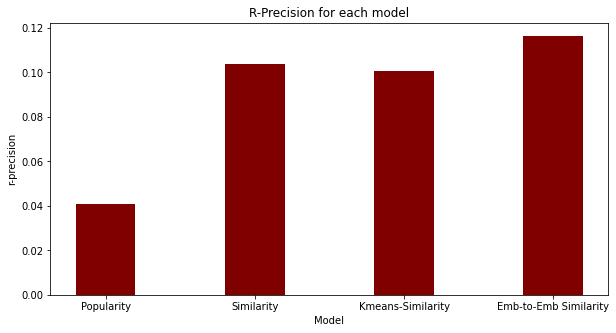

In [22]:
courses = results_df['Method']
values = results_df['R-Precision']
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("r-precision")
plt.title("R-Precision for each model")
plt.show()

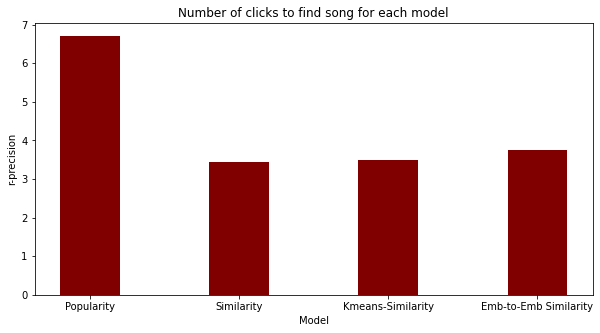

In [23]:
courses = results_df['Method']
values = results_df['Clicks']
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("r-precision")
plt.title("Number of clicks to find song for each model")
plt.show()

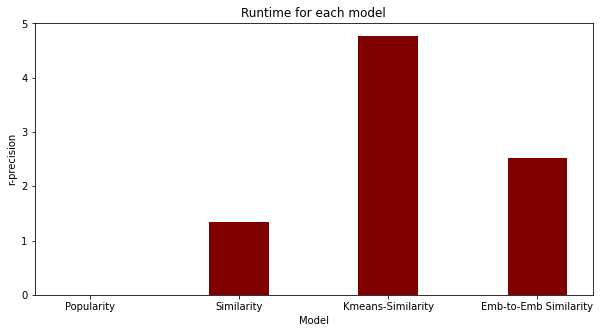

In [24]:
courses = results_df['Method']
values = results_df['Time']
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("r-precision")
plt.title("Runtime for each model")
plt.show()